# LAB 9-4 얼굴 찾기 : 전이학습 활용하기
***

In [1]:
!pip install tensorflow

  Using cached tensorflow-2.11.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-22.11.23-py2.py3-none-any.whl (26 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached grpcio-1.50.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached libclang-14.0.6-py2.py3-none-manylinux2010_x86_64.whl (14.1 MB)
  Using cached numpy-1.23.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorboard-2.11.0-py3-none-any.whl (6.0 MB)
  Using cached google_auth-2.14.1-py2.py3-none-any.whl (175 kB)
  Using cached cachetools-5.2.0-py3-none-any.whl (9.3 kB)
  Using cached google_auth_oauthlib-0.4.6

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread             # 이미지를 읽어 들인다
from skimage.transform import resize      # 이미지의 크기를 변경할 수 있다

In [3]:
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras import models, layers
from keras.models import Model

<Figure size 432x288 with 0 Axes>

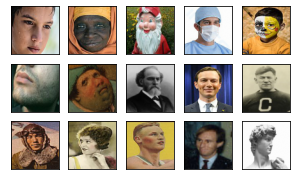

In [4]:
# 1. 사람 얼굴 이미지 준비
# 얼굴 데이터 불러오기

url = 'https://github.com/dknife/ML/raw/main/data/Proj2/faces/'

face_images = []
for i in range(15):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (75,75))
    face_images.append(img)

def plot_images(nRow, nCol, img):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize = (nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i, j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])

plot_images(3,5, face_images)

<Figure size 432x288 with 0 Axes>

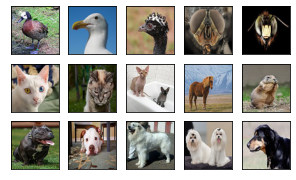

In [5]:
# 2. 사람 얼굴이 아닌 이미지 준비
# 동물 데이터 불러오기

url = 'https://github.com/dknife/ML/raw/main/data/Proj2/animals/'

animal_images = []
for i in range(15):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (75,75))
    animal_images.append(img)

plot_images(3,5, animal_images)

In [6]:
# 3. 학습을 위한 데이터 만들기
# 각 데이터에 레이블 제공
X = face_images + animal_images
# 얼굴 이미지는 1, 얼굴이 아닌 이미지는 0 - sparse_categorical_entropy 
y = [[1]]* len(face_images) + [[0]] * len(animal_images)
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(30, 75, 75, 3) (30, 1)


In [7]:
# 4. 사전 훈련된 모델 가져오기
# 이전에는 CNN모델을 일일이 구상해 주었은데 이번에는 사전 훈련된 모델을 가져와 사용
pre_trained_model = InceptionV3(input_shape=(75, 75, 3),
                                include_top=False,
                                weights=None)

In [8]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

In [9]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

# Flatten 계층 구성
my_layer = layers.Flatten()(last_output)
my_layer = layers.Dense(256, activation='relu')(my_layer)
my_layer = layers.Dense(256, activation='relu')(my_layer)
my_layer = layers.Dense(1, activation='sigmoid')(my_layer)

In [10]:
model = Model(pre_trained_model.input, my_layer)

# adam최적화 기법으로 컴파일
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[0][0]']

In [12]:
# 5. 전체 모델 새로 훈련시키기
# 100 에폭으로 학습
history = model.fit(X, y, epochs=100, shuffle=True)

Epoch 1/100
1/1 [==============================] - 9s 9s/step - loss: 0.2754 - accuracy: 0.4667
Epoch 2/100
1/1 [==============================] - 0s 116ms/step - loss: 0.4714 - accuracy: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 123ms/step - loss: 0.2682 - accuracy: 0.5667
Epoch 4/100
1/1 [==============================] - 0s 111ms/step - loss: 0.2650 - accuracy: 0.5333
Epoch 5/100
1/1 [==============================] - 0s 115ms/step - loss: 0.0451 - accuracy: 0.9667
Epoch 6/100
1/1 [==============================] - 0s 108ms/step - loss: 0.0193 - accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 113ms/step - loss: 5.5301e-04 - accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 112ms/step - loss: 4.0656e-04 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 0s 112ms/step - loss: 4.0828e-04 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 115ms/step - loss: 4.8075e-04 - accuracy: 1.0

1/1 [==============================] - 1s 715ms/step


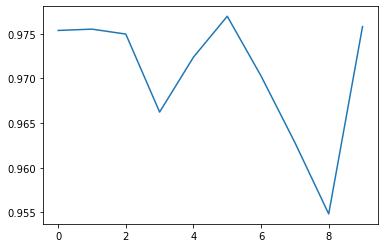

<Figure size 432x288 with 0 Axes>

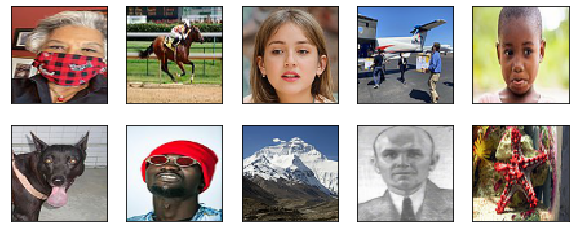

In [13]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/test_data/'

test_images = []
for i in range(10):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (75,75))
    test_images.append(img)

test_images = np.array(test_images)
test_result = model.predict(test_images)
plt.plot(test_result)

fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
    for j in range(5):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        if test_result[i*5+j] > 0.5:            
            ax[i, j].imshow(test_images[i*5+j],interpolation='nearest')

In [14]:
# 사전 학습된 모델의 능력을 유지하는 훈련
frozen = InceptionV3(input_shape=(75, 75, 3),
                     include_top=False,
                     weights='imagenet')
last_layer = frozen.get_layer('mixed7')
last_output = last_layer.output

# trainable을 talse로 지정하여 사전 학습된 파라미터가 변경되는것을 방지
for layer in frozen.layers:
    layer.trainable = False

In [15]:
my_layer = layers.Flatten()(last_output)
my_layer = layers.Dense(256, activation='relu')(my_layer)
my_layer = layers.Dense(256, activation='relu')(my_layer)
my_layer = layers.Dense(1, activation='sigmoid')(my_layer)

transfer_learner = Model(frozen.input, my_layer)
transfer_learner.summary()
transfer_learner.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 37, 37, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 37, 37, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 37, 37, 32)   0           ['batch_normalization_94[0]

In [16]:
# 100 에폭으로 훈련 진행
history = transfer_learner.fit(X, y, epochs=100, shuffle=True)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.1984 - accuracy: 0.6667
Epoch 2/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 49ms/step - loss: 1.0949e-05 - accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 46ms/step - loss: 3.9547e-07 - accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 49ms/step - loss: 8.2418e-08 - accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 49ms/step - loss: 2.8674e-08 - accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 48ms/step - loss: 1.1870e-08 - accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 50ms/step - loss: 5.7189e-09 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 0s 50ms/step - loss: 3.0894e-09 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 48ms/step - loss: 1.8182e-09 - accura

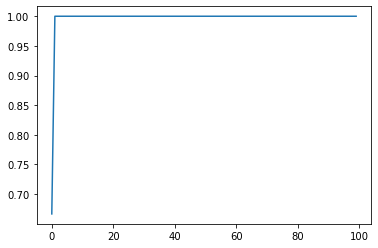

In [17]:
plt.plot(history.history['accuracy'])

1/1 [==============================] - 1s 676ms/step


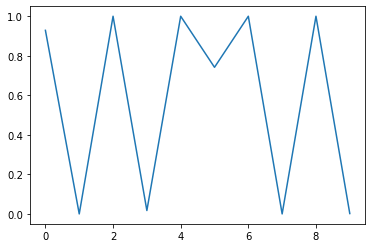

In [18]:
test_result = transfer_learner.predict(test_images)
plt.plot(test_result)

<Figure size 432x288 with 0 Axes>

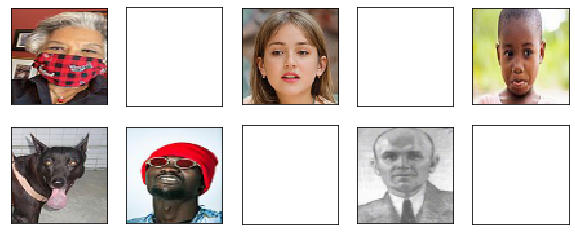

In [19]:
fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
    for j in range(5):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        if test_result[i*5+j] > 0.5:            
            ax[i, j].imshow(test_images[i*5+j],interpolation='nearest')

In [20]:
# 책에서 사용한 VGG 16 모델이 불러지지 않아 진행하지 못했습니다.
# 7. VGG 16 모델 사용하기
from tensorflow.python.keras.applications.vgg16 import VGG16

# VGG16모델 사용, 입력 크기는 75, 75, 3으로 입력
vgg16 = VGG16(weights='imagenet', include_top=False, 
              input_shape=(75, 75, 3))

ModuleNotFoundError: No module named 'tensorflow.python.keras.applications'

In [ ]:
vgg16.summary()

In [ ]:
last_layer = vgg16.get_layer('block4_pool')
last_output = last_layer.output

# 전과 같은 이유로 파라미터 변경 못하게 설정
for layer in vgg16.layers:
   layer.trainable = False

my_layer = layers.Flatten()(last_output)
my_layer = layers.Dense(32, activation='relu')(my_layer)
my_layer = layers.Dense(32, activation='relu')(my_layer)
my_layer = layers.Dense(1, activation='sigmoid')(my_layer)

transfer_learner = Model(vgg16.input, my_layer)

transfer_learner.compile(optimizer='adam',
                         loss='mse',
                         metrics=['accuracy'])

In [ ]:
# 모델이 어떻게 구성되어 있는지 확인
transfer_learner.summary()

In [ ]:
# 100 에폭으로 훈련시킨 후 그 정확도 저장
history = transfer_learner.fit(X, y, epochs=100, shuffle=True)
plt.plot(history.history['accuracy'])

In [ ]:
# 학습 시킨 모델 예측
test_result = transfer_learner.predict(test_images)
plt.plot(test_result)

In [ ]:
# 0.5 이상의 값을 얻은 이미지만 출력
fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
    for j in range(5):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        if test_result[i*5+j] > 0.5:            
            ax[i, j].imshow(test_images[i*5+j],interpolation='nearest')